In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

Load dataframes and filter them.



In [2]:
import pandas as pd
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train = train.loc[train.is_colon==1].drop(['is_colon', 'is_aca_cancer'],axis = 1)
train['is_non_cancer']=train['is_non_cancer'].astype('str')
test = test.loc[test.is_colon==1].drop(['is_colon', 'is_aca_cancer'],axis = 1)
test['is_non_cancer']=test['is_non_cancer'].astype('str')
train

,filepath,is_non_cancer
0,data\colon_image_sets\colon_n\colonn3528.jpeg,True
1,data\colon_image_sets\colon_n\colonn3115.jpeg,True
2,data\colon_image_sets\colon_n\colonn3012.jpeg,True
3,data\colon_image_sets\colon_n\colonn4184.jpeg,True
4,data\colon_image_sets\colon_n\colonn2768.jpeg,True
...,...,...
7995,data\colon_image_sets\colon_aca\colonca2665.jpeg,False
7996,data\colon_image_sets\colon_aca\colonca1066.jpeg,False
7997,data\colon_image_sets\colon_aca\colonca3033.jpeg,False
7998,data\colon_image_sets\colon_aca\colonca1014.jpeg,False


In [3]:
train_datagen = ImageDataGenerator(rescale=1/255,
#                                    rotation_range=15,
#                                   zoom_range=0.2,
#                                   horizontal_flip=True,
                                  )
test_datagen = ImageDataGenerator(rescale=1/255,
#                                    rotation_range=15,
#                                   zoom_range=0.2,
#                                   horizontal_flip=True,
                                 )
val_datagen = ImageDataGenerator(rescale=1/255,
#                                    rotation_range=15,
#                                   zoom_range=0.2,
#                                   horizontal_flip=True,
                                )

target_size = (256,256)

In [4]:
from sklearn.model_selection import train_test_split
train_df, validate_df = train_test_split(train, test_size=0.20, random_state=42)
batch_size = 40

train_datagen = train_datagen.flow_from_dataframe(train_df,
                                  x_col='filepath',
                                  y_col='is_non_cancer',
                                  target_size=target_size,
                                  batch_size=batch_size,
                                  class_mode='binary',)
val_datagen = val_datagen.flow_from_dataframe(validate_df,
                                  x_col='filepath',
                                  y_col='is_non_cancer',
                                  target_size=target_size,
                                  batch_size=batch_size,
                                  class_mode='binary',
                                  shuffle=False)
test_datagen = test_datagen.flow_from_dataframe(test,
                                  x_col='filepath',
                                  y_col='is_non_cancer',
                                  target_size=target_size,
                                  batch_size=batch_size,
                                  class_mode='binary',
                                  shuffle=False)

Found 6400 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    train_df, 
    x_col='filepath',
    y_col='is_non_cancer',
    target_size=target_size,
    class_mode='binary'
)

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Model

In [5]:
input_shape = (256,256,3)

model = Sequential()

# Add convolutional/pooling layers

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=input_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=input_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3,3),input_shape=input_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add flatten layer
model.add(Flatten())

# Add dense/dropout layers + activation functions

model.add(Dense(128))
model.add(Activation('relu'))# relu activation function for deep layer
model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation('sigmoid'))# sigmoid activation function for last layer for binary classification

# Print summary of your model
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 115200)            0

In [6]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 20
history = model.fit(train_datagen,
                    steps_per_epoch= len(train_df)//batch_size, 
                    epochs=epochs,
                    validation_data=val_datagen,
                    validation_steps= len(validate_df)//batch_size)

Epoch 1/20
160/160 [==============================] - 204s 1s/step - loss: 0.9785 - accuracy: 0.4945 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 2/20
160/160 [==============================] - 198s 1s/step - loss: 0.6932 - accuracy: 0.4834 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 3/20
160/160 [==============================] - 198s 1s/step - loss: 0.6932 - accuracy: 0.5054 - val_loss: 0.6931 - val_accuracy: 0.5025
Epoch 4/20
160/160 [==============================] - 197s 1s/step - loss: 0.6931 - accuracy: 0.5130 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 5/20
160/160 [==============================] - 202s 1s/step - loss: 0.6932 - accuracy: 0.4903 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 6/20
160/160 [==============================] - 199s 1s/step - loss: 0.6931 - accuracy: 0.5031 - val_loss: 0.6931 - val_accuracy: 0.4975
Epoch 7/20
160/160 [==============================] - 195s 1s/step - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0.6932 - val_accuracy: 0.4975

In [ ]:
FAST_RUN = True
epochs = 5 if FAST_RUN else 50

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
earlystop = EarlyStopping(patience=10)
callbacks = [earlystop, learning_rate_reduction]
history = model.fit(train_datagen,
                              epochs=epochs,
                              validation_data=val_datagen,
                              validation_steps=total_validate // batch_size,
                              steps_per_epoch=total_train // batch_size,
                              callbacks=callbacks)  # Los callbacks definidos antes

In [7]:
len(validate_df)

1600

In [8]:
model.save_weights("model.h5")

In [10]:
import pickle
with open('objs.pkl', 'wb') as f:
    pickle.dump(history, f)

TypeError: cannot pickle 'weakref' object

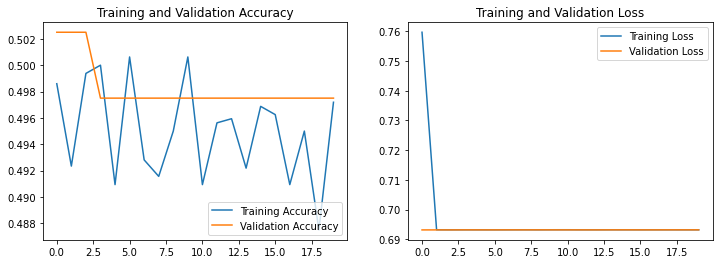

In [12]:
import matplotlib.pyplot as plt
# Plot model accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
test_loss, test_acc = model.evaluate(test_datagen, steps=50)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

C:\Users\USUARIO\Programs\anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test accuracy: 0.5
Test loss: 0.6931498050689697


----------

In [14]:
train_datagen = ImageDataGenerator(rescale=1/255,
#                                    rotation_range=15,
#                                   zoom_range=0.2,
#                                   horizontal_flip=True,
                                  )
test_datagen = ImageDataGenerator(rescale=1/255,
#                                    rotation_range=15,
#                                   zoom_range=0.2,
#                                   horizontal_flip=True,
                                 )
val_datagen = ImageDataGenerator(rescale=1/255,
#                                    rotation_range=15,
#                                   zoom_range=0.2,
#                                   horizontal_flip=True,
                                )

target_size = (256,256)
# ----
from sklearn.model_selection import train_test_split
train_df, validate_df = train_test_split(train, test_size=0.20, random_state=42)
batch_size = 40

train_datagen = train_datagen.flow_from_dataframe(train_df,
                                  x_col='filepath',
                                  y_col='is_non_cancer',
                                  target_size=target_size,
                                  batch_size=batch_size,
                                  class_mode='binary',)
val_datagen = val_datagen.flow_from_dataframe(validate_df,
                                  x_col='filepath',
                                  y_col='is_non_cancer',
                                  target_size=target_size,
                                  batch_size=batch_size,
                                  class_mode='binary',
                                  shuffle=False)
test_datagen = test_datagen.flow_from_dataframe(test,
                                  x_col='filepath',
                                  y_col='is_non_cancer',
                                  target_size=target_size,
                                  batch_size=batch_size,
                                  class_mode='binary',
                                  shuffle=False)
# ----
input_shape = (256,256,3)

model2 = Sequential()

# Add convolutional/pooling layers

model2.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=input_shape, activation='relu',))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=input_shape, activation='relu',))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(filters=128, kernel_size=(3,3),input_shape=input_shape, activation='relu',))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Add flatten layer
model2.add(Flatten())

# Add dense/dropout layers + activation functions

model2.add(Dense(128))
model2.add(Activation('relu'))# relu activation function for deep layer
model2.add(Dropout(0.2))

model2.add(Dense(1))
model2.add(Activation('sigmoid'))# sigmoid activation function for last layer for binary classification

# Print summary of your model
model2.summary() 
# ----

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 20
history2 = model2.fit(train_datagen,
                    steps_per_epoch= len(train_df)//batch_size, 
                    epochs=epochs,
                    validation_data=val_datagen,
                    validation_steps= len(validate_df)//batch_size)

Found 6400 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max

In [15]:
test_loss, test_acc = model2.evaluate(test_datagen, steps=50)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

50/50 [==============================] - 20s 396ms/step - loss: 0.2959 - accuracy: 0.9395
Test accuracy: 0.9394999742507935
Test loss: 0.29586341977119446


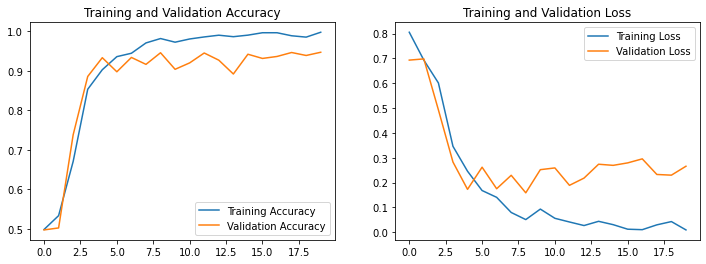

In [16]:

# Plot model accuracy and loss
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
model2.save_weights("model.h5")